## Kaggle Rainfall Prediction

https://www.kaggle.com/c/how-much-did-it-rain-ii/overview

Rainfall is highly variable across space and time, making it notoriously tricky to measure. Rain gauges can be an effective measurement tool for a specific location, but it is impossible to have them everywhere. In order to have widespread coverage, data from weather radars is used to estimate rainfall nationwide. Unfortunately, these predictions never exactly match the measurements taken using rain gauges.

Recently, in an effort to improve their rainfall predictors, the U.S. National Weather Service upgraded their radar network to be polarimetric. These polarimetric radars are able to provide higher quality data than conventional Doppler radars because they transmit radio wave pulses with both horizontal and vertical orientations. 

Dual pulses make it easier to infer the size and type of precipitation because rain drops become flatter as they increase in size, whereas ice crystals tend to be elongated vertically.

In this competition, you are given snapshots of polarimetric radar values and asked to predict the hourly rain gauge total. A word of caution: many of the gauge values in the training dataset are implausible (gauges may get clogged, for example).

----

The training data consists of NEXRAD and MADIS data collected on 20 days between Apr and Aug 2014 over midwestern corn-growing states. Time and location information have been censored, and the data have been shuffled so that they are not ordered by time or place. The test data consists of data from the same radars and gauges over the remaining days in that month. 

To understand the data, you have to realize that there are multiple radar observations over the course of an hour, and only one gauge observation (the 'Expected'). That is why there are multiple rows with the same 'Id'.

The columns in the datasets are:

1. Id:  
    A unique number for the set of observations over an hour at a gauge.
2. minutes_past:  
    For each set of radar observations, the minutes past the top of the hour that the radar observations were carried out. Radar observations are snapshots at that point in time.
3. radardist_km:  
    Distance of gauge from the radar whose observations are being reported.
4. Ref:  
    Radar reflectivity in km
5. Ref_5x5_10th:   
    10th percentile of reflectivity values in 5x5 neighborhood around the gauge.
6. Ref_5x5_50th:   
    50th percentile
7. Ref_5x5_90th:   
    90th percentile
8. RefComposite:  
    Maximum reflectivity in the vertical column above gauge.  In dBZ.
9. RefComposite_5x5_10th
10. RefComposite_5x5_50th
11. RefComposite_5x5_90th
12. RhoHV:  
    Correlation coefficient (unitless)
13. RhoHV_5x5_10th
14. RhoHV_5x5_50th
15. RhoHV_5x5_90th
16. Zdr:    
    Differential reflectivity in dB
17. Zdr_5x5_10th
18. Zdr_5x5_50th
19. Zdr_5x5_90th
20. Kdp:  
    Specific differential phase (deg/km)
21. Kdp_5x5_10th
22. Kdp_5x5_50th
23. Kdp_5x5_90th
24. Expected:  
    Actual gauge observation in mm at the end of the hour.


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

from sklearn.linear_model import LinearRegression
lrmdl = LinearRegression()

from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_squared_error

In [2]:
pd.options.display.float_format = '{:,.4f}'.format
sns.set_style(style='darkgrid')

In [3]:
df = pd.read_csv('Rainfall-train.csv')

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,"13,765,201.0000","592,336.9866","340,856.0863",1.0000,"296,897.0000","592,199.0000","889,582.0000","1,180,945.0000"
minutes_past,"13,765,201.0000",29.5237,17.3081,0.0000,15.0000,30.0000,44.0000,59.0000
radardist_km,"13,765,201.0000",11.0679,4.2066,0.0000,9.0000,11.0000,14.0000,21.0000
Ref,"6,349,375.0000",22.9267,10.3552,-31.0000,16.0000,22.5000,29.5000,71.0000
Ref_5x5_10th,"5,283,988.0000",19.9523,9.2082,-32.0000,14.0000,20.0000,26.0000,62.5000
Ref_5x5_50th,"6,356,482.0000",22.6103,10.0530,-32.0000,16.0000,22.5000,29.0000,69.0000
Ref_5x5_90th,"7,551,281.0000",25.8985,11.1096,-28.5000,18.0000,25.5000,33.5000,72.5000
RefComposite,"6,716,343.0000",24.7111,10.6896,-32.0000,17.5000,24.0000,31.5000,92.5000
RefComposite_5x5_10th,"5,755,673.0000",22.1582,9.7027,-31.0000,16.0000,22.0000,28.5000,66.0000
RefComposite_5x5_50th,"6,711,663.0000",24.4208,10.4245,-27.5000,17.5000,24.0000,31.5000,71.0000


In [7]:
dfd = df[~(df.Ref.isnull() & df.Ref_5x5_10th.isnull() & df.Ref_5x5_50th.isnull() & df.Ref_5x5_90th.isnull() &
           df.RefComposite.isnull() & df.RefComposite_5x5_10th.isnull() & df.RefComposite_5x5_50th.isnull() & df.RefComposite_5x5_90th.isnull() &
           df.RhoHV.isnull() & df.RhoHV_5x5_10th.isnull() & df.RhoHV_5x5_50th.isnull() & df.RhoHV_5x5_90th.isnull() &
           df.Zdr.isnull() & df.Zdr_5x5_10th.isnull() & df.Zdr_5x5_50th.isnull() & df.Zdr_5x5_90th.isnull() &
           df.Kdp.isnull() & df.Kdp_5x5_10th.isnull() & df.Kdp_5x5_50th.isnull() & df.Kdp_5x5_90th.isnull())].copy()

In [8]:
dfd.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,"8,476,966.0000","591,071.4360","340,619.3942",2.0000,"294,470.0000","591,485.0000","889,741.7500","1,180,945.0000"
minutes_past,"8,476,966.0000",29.3391,17.2152,0.0000,14.0000,29.0000,44.0000,59.0000
radardist_km,"8,476,966.0000",9.6347,3.9964,0.0000,7.0000,10.0000,12.0000,21.0000
Ref,"6,349,375.0000",22.9267,10.3552,-31.0000,16.0000,22.5000,29.5000,71.0000
Ref_5x5_10th,"5,283,988.0000",19.9523,9.2082,-32.0000,14.0000,20.0000,26.0000,62.5000
Ref_5x5_50th,"6,356,482.0000",22.6103,10.0530,-32.0000,16.0000,22.5000,29.0000,69.0000
Ref_5x5_90th,"7,551,281.0000",25.8985,11.1096,-28.5000,18.0000,25.5000,33.5000,72.5000
RefComposite,"6,716,343.0000",24.7111,10.6896,-32.0000,17.5000,24.0000,31.5000,92.5000
RefComposite_5x5_10th,"5,755,673.0000",22.1582,9.7027,-31.0000,16.0000,22.0000,28.5000,66.0000
RefComposite_5x5_50th,"6,711,663.0000",24.4208,10.4245,-27.5000,17.5000,24.0000,31.5000,71.0000


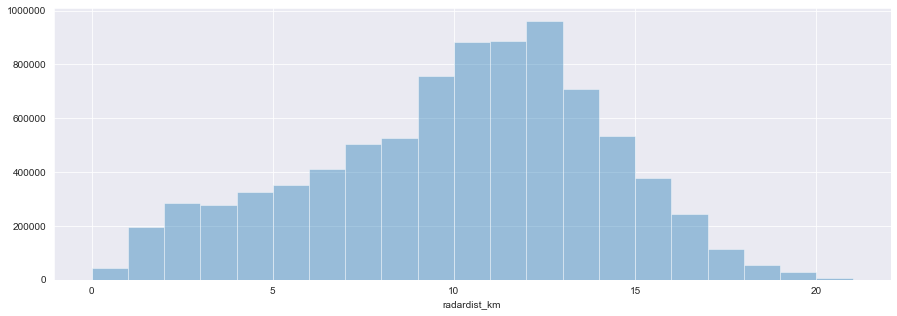

In [12]:
plt.figure(figsize=[15,5])
sns.distplot(dfd.radardist_km, kde=False, bins=21);
plt.show()

In [13]:
dfd.groupby(['radardist_km']).count()

,Id,minutes_past,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th,RefComposite,RefComposite_5x5_10th,RefComposite_5x5_50th,RefComposite_5x5_90th,...,RhoHV_5x5_90th,Zdr,Zdr_5x5_10th,Zdr_5x5_50th,Zdr_5x5_90th,Kdp,Kdp_5x5_10th,Kdp_5x5_50th,Kdp_5x5_90th,Expected
radardist_km,,,,,,,,,,,,,,,,,,,,,
0.0000,44387,44387,41525,35643,43575,44370,44198,42845,44321,44386,...,44351,41521,35767,43119,44351,21163,14108,20369,30519,44387
1.0000,195999,195999,187453,175154,189933,195100,193014,189281,193796,195780,...,194708,185042,169715,188562,194708,106048,85486,104544,135927,195999
2.0000,283517,283517,257389,236088,258940,277470,267318,253323,268416,280573,...,276007,252795,229495,254445,276007,157514,136377,157235,183920,283517
3.0000,277181,277181,236119,212456,236483,263921,246993,227931,247369,270038,...,256371,225839,200095,226170,256371,147022,127293,147108,170716,277181
4.0000,326249,326249,268675,242055,268475,301296,283505,260411,283055,312453,...,287050,251505,224065,251098,287050,186887,163306,187438,214062,326249
5.0000,350243,350243,276747,245181,276056,315186,296254,267873,295377,330968,...,290914,250094,218653,249193,290914,193557,167197,193619,223848,350243
6.0000,410272,410272,325185,289246,325375,367073,349266,317961,349114,386753,...,328729,284635,250136,284320,328729,235642,201566,236255,274482,410272
7.0000,505215,505215,395473,347921,396054,447212,428169,386893,428581,473539,...,390398,337639,294800,338101,390398,294954,250118,296003,345256,505215
8.0000,525639,525639,404774,352812,405630,461673,436945,390918,437358,488675,...,394394,337104,290403,336894,394394,299909,252131,300636,353784,525639


In [14]:
dfd[dfd.radardist_km == 0].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,"44,387.0000","582,499.6970","331,899.2108",361.0000,"300,678.0000","587,190.0000","861,348.0000","1,180,685.0000"
minutes_past,"44,387.0000",29.5442,17.3259,0.0000,15.0000,30.0000,45.0000,59.0000
radardist_km,"44,387.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Ref,"41,525.0000",13.5547,15.2686,-31.0000,2.0000,14.0000,25.5000,59.0000
Ref_5x5_10th,"35,643.0000",7.1517,15.5148,-32.0000,-5.5000,6.5000,20.0000,50.5000
Ref_5x5_50th,"43,575.0000",12.4990,14.9571,-32.0000,1.5000,12.5000,24.0000,55.5000
Ref_5x5_90th,"44,370.0000",21.4406,13.5919,-28.5000,13.0000,22.5000,31.0000,60.5000
RefComposite,"44,198.0000",19.9186,14.7855,-28.0000,10.0000,21.0000,31.0000,61.0000
RefComposite_5x5_10th,"42,845.0000",14.6080,15.7322,-30.5000,2.5000,15.5000,27.0000,56.0000
RefComposite_5x5_50th,"44,321.0000",19.4179,14.4985,-27.5000,9.5000,20.0000,30.5000,58.5000


In [47]:
dfdRef = dfd[['Ref','Ref_5x5_10th','Ref_5x5_50th','Ref_5x5_90th','RefComposite','RefComposite_5x5_10th','RefComposite_5x5_50th','RefComposite_5x5_90th']][dfd.radardist_km == 0][~(dfd.Ref.isnull() | dfd.Ref_5x5_10th.isnull() | dfd.Ref_5x5_50th.isnull() | dfd.Ref_5x5_90th.isnull())].copy()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


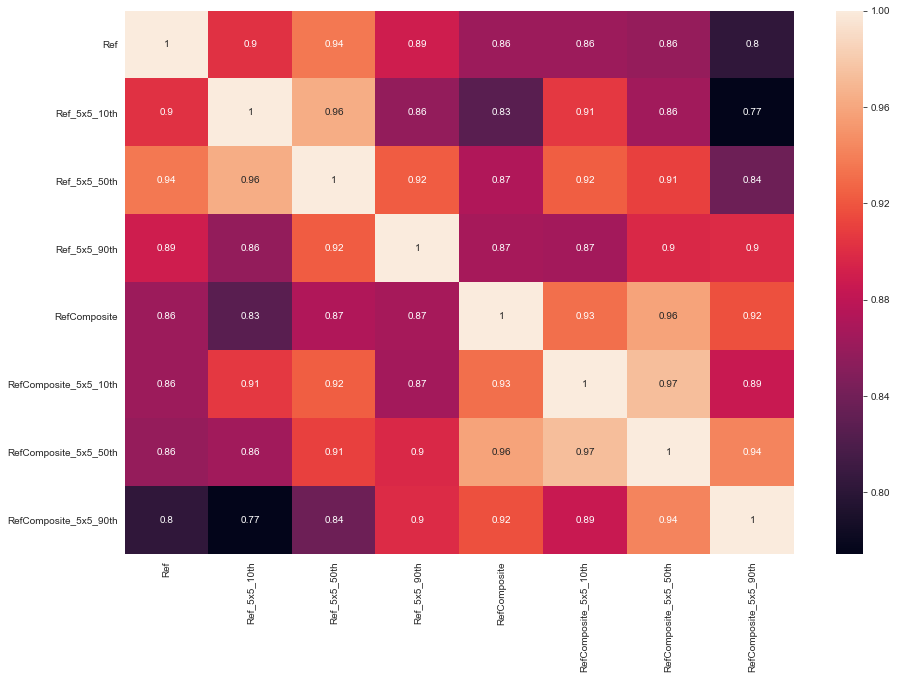

In [48]:
plt.figure(figsize=[15,10])
sns.heatmap(dfdRef.corr(), annot=True);
plt.show()

In [149]:
dfd[['Ref','Ref_5x5_10th','Ref_5x5_50th','Ref_5x5_90th',
    'Ref_5x5_50th_mdn','Ref_5x5_90th_mdn']][~dfd.Ref.isnull() & 
                                           ~dfd.Ref_5x5_90th.isnull()].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Ref,"6,349,288.0000",22.9268,10.3551,-31.0000,16.0000,22.5000,29.5000,71.0000
Ref_5x5_10th,"5,269,105.0000",19.9838,9.1951,-32.0000,14.5000,20.0000,26.0000,62.5000
Ref_5x5_50th,"6,349,288.0000",22.6340,10.0144,-32.0000,16.0000,22.5000,29.0000,69.0000
Ref_5x5_90th,"6,349,288.0000",28.1252,10.2823,-28.5000,21.5000,27.5000,35.0000,72.5000
Ref_5x5_50th_mdn,"6,349,288.0000",22.5512,8.5243,-29.2500,17.0000,22.5000,28.5000,61.0000
Ref_5x5_90th_mdn,"6,349,288.0000",27.2976,8.8666,-24.5000,21.5000,27.2500,33.5000,64.5000


In [155]:
dfd[['Ref','Ref_5x5_10th','Ref_5x5_50th','Ref_5x5_90th',
    'Ref_5x5_50th_mdn','Ref_5x5_90th_mdn']][~dfd.Ref.isnull() & 
                                           ~dfd.Ref_5x5_90th.isnull()].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Ref,"6,349,288.0000",22.9268,10.3551,-31.0000,16.0000,22.5000,29.5000,71.0000
Ref_5x5_10th,"6,349,288.0000",18.5429,9.6335,-50.0000,12.5000,18.5000,25.0000,95.5000
Ref_5x5_50th,"6,349,288.0000",22.6340,10.0144,-32.0000,16.0000,22.5000,29.0000,69.0000
Ref_5x5_90th,"6,349,288.0000",28.1252,10.2823,-28.5000,21.5000,27.5000,35.0000,72.5000
Ref_5x5_50th_mdn,"6,349,288.0000",22.2642,2.4030,12.5000,20.5000,22.5000,24.0000,25.0000
Ref_5x5_90th_mdn,"6,349,288.0000",25.9862,2.4518,20.5000,23.5000,26.0000,28.0000,29.0000


In [154]:
dfd.Ref_5x5_50th[~dfd.Ref.isnull() & 
                   dfd.Ref_5x5_50th.isnull() & 
                   ~dfd.Ref_5x5_90th.isnull()] = dfd[~dfd.Ref.isnull() & 
                                                     dfd.Ref_5x5_50th.isnull() & 
                                                     ~dfd.Ref_5x5_90th.isnull()].groupby('radardist_km')['Ref'].transform('median')

dfd['Ref_5x5_50th_mdn'] = dfd[~dfd.Ref_5x5_50th.isnull()].groupby('radardist_km')['Ref_5x5_50th'].transform('median')

dfd['Ref_5x5_90th_mdn'] = dfd[~dfd.Ref_5x5_90th.isnull()].groupby('radardist_km')['Ref_5x5_90th'].transform('median')

dfd.Ref_5x5_10th[dfd.Ref_5x5_10th.isnull()] = (2*dfd.Ref_5x5_50th_mdn) - dfd.Ref_5x5_90th_mdn

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [159]:
dfd[['radardist_km','Ref','Ref_5x5_10th','Ref_5x5_50th',
     'Ref_5x5_90th']][~dfd.Ref.isnull()].groupby('radardist_km').agg (
                            {
#                                 'Ref':(['count','mean','median']),
#                                 'Ref_5x5_10th':(['count','mean','median']),
#                                 'Ref_5x5_50th':(['count','mean','median']),
#                                 'Ref_5x5_50th_1':(['count','mean','median']),
#                                 'Ref_5x5_90th':(['count','mean','median'])
                                'Ref':'max',
                                'Ref_5x5_10th':'max',
                                'Ref_5x5_50th':'max',
                                'Ref_5x5_90th':'max'

                            }
                        )

,Ref,Ref_5x5_10th,Ref_5x5_50th,Ref_5x5_90th
radardist_km,,,,
0.0000,59.0000,50.5000,55.5000,60.5000
1.0000,62.0000,95.5000,61.0000,67.0000
2.0000,64.0000,77.5000,61.0000,65.0000
3.0000,64.5000,80.5000,61.0000,65.5000
4.0000,62.5000,81.5000,61.0000,67.0000
5.0000,70.0000,78.5000,68.5000,71.0000
6.0000,66.0000,71.0000,61.0000,68.0000
7.0000,68.0000,78.0000,62.5000,68.0000
8.0000,68.5000,79.7500,65.0000,70.5000
